<a href="https://colab.research.google.com/github/pilartoussaint/Stumed-Learning-Analytics/blob/main/StuMed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StuMed: Análisis de Retención y Desempeño Académico en Stumed

## Descripción del proyecto

*Sobre Stumed*

Stumed es una plataforma líder en educación médica continua, especializada en la preparación de médicos generales para el Examen Nacional de Aspirantes a Residencias Médicas (ENARM) en México. La plataforma ofrece un ecosistema de aprendizaje integral que incluye contenido multimedia, evaluaciones interactivas y simulacros de examen, diseñados para acompañar al estudiante en uno de los retos profesionales más exigentes de su carrera.

A diferencia de otros modelos de suscripción, Stumed opera bajo un esquema de pago único y obligatorio por el curso completo. Esto elimina la deserción financiera, pero traslada el desafío hacia la retención académica. El éxito de la empresa no solo depende de la venta del curso, sino de asegurar que el estudiante mantenga un nivel de compromiso óptimo para concluir el temario antes de la fecha crítica del examen en septiembre.

*Objetivo del Proyecto*


El objetivo principal de este análisis es transformar los datos brutos de actividad almacenados en Moodle en insights estratégicos que permitan optimizar la experiencia del usuario y maximizar las probabilidades de éxito del estudiante.

A través de este proyecto se busca:

1. Identificar Patrones de Compromiso: Determinar cómo influye la fecha de inscripción en la constancia y el tiempo dedicado al estudio.

2. Monitorear la Salud Académica: Detectar tempranamente a los "estudiantes fantasma" (usuarios que han pagado pero han cesado su actividad) mediante métricas de uso activo y progresión.

3. Validar Hipótesis de Aprendizaje: Correlacionar el volumen de actividades completadas con el desempeño en los quizes para identificar los comportamientos que conducen a mejores resultados.

4. Optimizar la Planificación Curricular: Proporcionar métricas basadas en datos para que el equipo académico de Stumed pueda ajustar el ritmo de entrega de contenidos según la fatiga detectada en los estudiantes a lo largo del año.

### Descripción de los datos

### 1. DF: estudiantes_activos

Columnas

1. time: fecha de la actividad
2. user_name: nombre completo de los alumnos
3. event_context: qué hicieron específicamente
4. event_name: qué actividad en general hicieron. ej: quiz, clase, etc
5. description: descripción específica de qué hizo

## Limpieza y exploración de datos

In [268]:
#Importar librerías en general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### df_estudiantes_activos

In [269]:
#Leer df
df_estudiantes_activos = pd.read_csv('/estudiantes_activos.csv')

In [270]:
#visualizar df: info, columnas, dtypes
print(df_estudiantes_activos.info())
print()
#Modificar los nombres de las columnas
df_estudiantes_activos.columns = ['time', 'user_name', 'event_context', 'event_name']
#Modificar time dtype
df_estudiantes_activos['time'] = pd.to_datetime(df_estudiantes_activos['time'], format='%d/%m/%y, %H:%M:%S')
# Verificación
print(df_estudiantes_activos['time'].dtype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789495 entries, 0 to 789494
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Time            789495 non-null  object
 1   User full name  789495 non-null  object
 2   Event context   789495 non-null  object
 3   Event name      789495 non-null  object
dtypes: object(4)
memory usage: 24.1+ MB
None

datetime64[ns]


In [271]:
#Eliminar filas enteras donde 'user_name = StuMED Admin'
df_estudiantes_activos = df_estudiantes_activos[df_estudiantes_activos['user_name'] != 'StuMED Admin']

In [272]:
#Checar valores duplicados
print(df_estudiantes_activos.duplicated().sum())
#Ver los valores duplicados
df_estudiantes_activos[df_estudiantes_activos.duplicated()]
# Elimina filas donde el tiempo, el usuario y el evento sean exactamente iguales
df_estudiantes_activos = df_estudiantes_activos.drop_duplicates(subset=['time', 'user_name', 'event_name'])

# Verifica cuántas filas quedaron
print(f"Filas tras limpieza: {len(df_estudiantes_activos)}")

4520
Filas tras limpieza: 772666


In [273]:
#Verificar qué fechas abarca
#Fecha mínima
print(df_estudiantes_activos['time'].min())
#Fecha máxima
print(df_estudiantes_activos['time'].max())

2024-10-15 11:20:43
2025-10-08 19:37:56


### df_alumnos_inscripciones

In [274]:
#Leer df_alumnos_inscripciones
df_alumnos_inscripciones = pd.read_excel('/alumnos_inscripciones.xlsx')

In [275]:
#Explorar df con info
print(df_alumnos_inscripciones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_name        134 non-null    object
 1   enrolment_start  134 non-null    object
dtypes: object(2)
memory usage: 2.2+ KB
None


In [276]:
#contar valores unicos de user_name
print(df_alumnos_inscripciones['user_name'].nunique())

133


In [277]:
#Checar valores duplicados
print(df_alumnos_inscripciones.duplicated().sum())
#Ver los valores duplicados
df_alumnos_inscripciones[df_alumnos_inscripciones.duplicated()]
#eliminar valor duplicado
df_alumnos_inscripciones = df_alumnos_inscripciones.drop_duplicates(subset=['user_name'])
#Verificar
print(df_alumnos_inscripciones.duplicated().sum())
#cuantos usuarios quedan
print(df_alumnos_inscripciones['user_name'].nunique())

1
0
133


In [278]:
#Verficar valores ausentes
print(df_alumnos_inscripciones.isnull().sum())

user_name          0
enrolment_start    0
dtype: int64


In [279]:
#Modificar columna enrolment_start a datetime
df_alumnos_inscripciones['enrolment_start'] = pd.to_datetime(
    df_alumnos_inscripciones['enrolment_start'].str.strip(),
    format='%A, %d %B %Y, %I:%M %p',
    errors='coerce'
)

# Verificación
print(df_alumnos_inscripciones['enrolment_start'].head())

0   2024-10-22 00:01:00
1   2024-10-15 08:31:00
2   2024-10-15 08:31:00
3   2025-01-28 20:23:00
4   2025-01-10 21:03:00
Name: enrolment_start, dtype: datetime64[ns]


## Métricas

### KPIs de Engagement y Retención (El "Pulso" del Estudiante)

#### DAU/MAU Ratio (Stickiness): Usuarios Activos Diarios / Usuarios Activos Mensuales

¿Qué porcentaje de tus alumnos mensuales entran diario? Un ratio alto indica que el curso es parte de su rutina diaria de estudio.

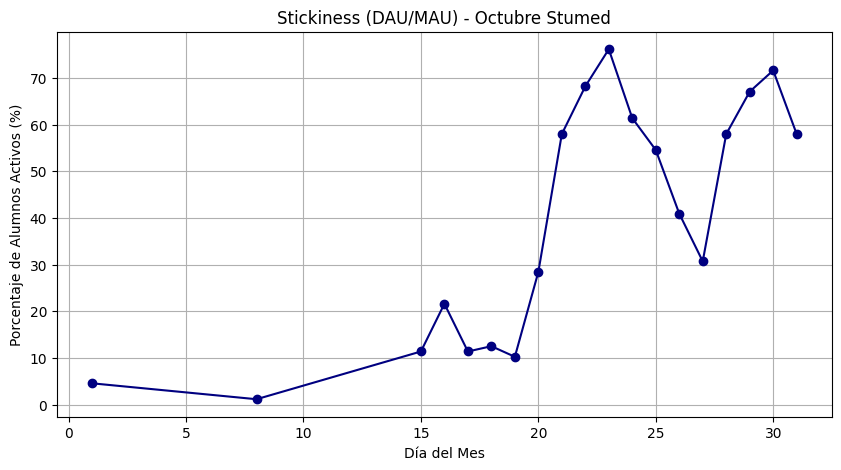

In [280]:
# Obtener métrica DAU/MAU usurios activos diarios / Usuarios activos mensuales para el mes de Octubre.
#Obtener el mes de octubre
df_estudiantes_activos_octubre = df_estudiantes_activos[df_estudiantes_activos['time'].dt.month == 10]
#Obtener número de valores únicos por día en el mes de octubre
dau_octubre = df_estudiantes_activos_octubre.groupby(df_estudiantes_activos_octubre['time'].dt.day)['user_name'].nunique()
#Obtener número de valores únicos en el mes de octubre
mau_octubre = df_estudiantes_activos_octubre['user_name'].nunique()
#Obtener ratio
dau_mau_ratio_octubre = dau_octubre / mau_octubre
# Multiplicar por 100 para tener porcentajes
dau_mau_ratio_octubre = (dau_octubre / mau_octubre) * 100

# Graficar
plt.figure(figsize=(10,5))
dau_mau_ratio_octubre.plot(kind='line', marker='o', color='navy')
plt.title('Stickiness (DAU/MAU) - Octubre Stumed')
plt.xlabel('Día del Mes')
plt.ylabel('Porcentaje de Alumnos Activos (%)')
plt.grid(True)
plt.show()


Conclusión: coincide con que el 23 de octubre inician clases los alumnos, vemos que algunos alumnos se metieron desde antes a revisar la plataforma, pero la mayoría entró al momento en que inició el curso.

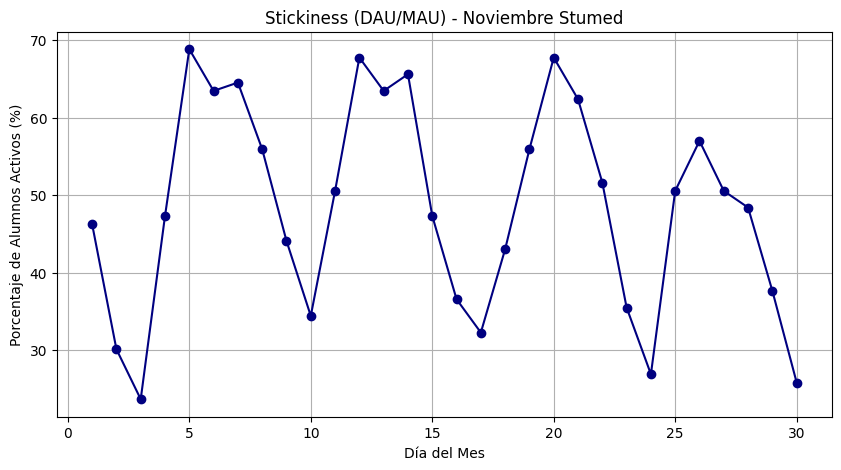

In [281]:
#DAU/MAU Noviembre
#Obtener el mes de noviembre
df_estudiantes_activos_noviembre = df_estudiantes_activos[df_estudiantes_activos['time'].dt.month == 11]
#Obtener número de valores únicos por día en el mes de noviembre
dau_noviembre = df_estudiantes_activos_noviembre.groupby(df_estudiantes_activos_noviembre['time'].dt.day)['user_name'].nunique()
#Obtener número de valores únicos en el mes de noviembre
mau_noviembre = df_estudiantes_activos_noviembre['user_name'].nunique()
#Obtener ratio
dau_mau_ratio_noviembre = dau_noviembre / mau_noviembre
# Multiplicar por 100 para tener porcentajes
dau_mau_ratio_noviembre = (dau_noviembre / mau_noviembre) * 100

# Graficar
plt.figure(figsize=(10,5))
dau_mau_ratio_noviembre.plot(kind='line', marker='o', color='navy')
plt.title('Stickiness (DAU/MAU) - Noviembre Stumed')
plt.xlabel('Día del Mes')
plt.ylabel('Porcentaje de Alumnos Activos (%)')
plt.grid(True)
plt.show()

Observamos que en noviembre tenemos un máximo del 70% de los estudiantes conectados, lo cual nos indica que es un mes es el que varios se mantienen conectados. Los días en que no hay muchos usuarios conectados son los fines de semana, sin embargo hay fines de semana que tenemos hasta un 30-40% de los usuarios conectados. Es un buen mes porque los estudiantes están entusiasmados de iniciar.

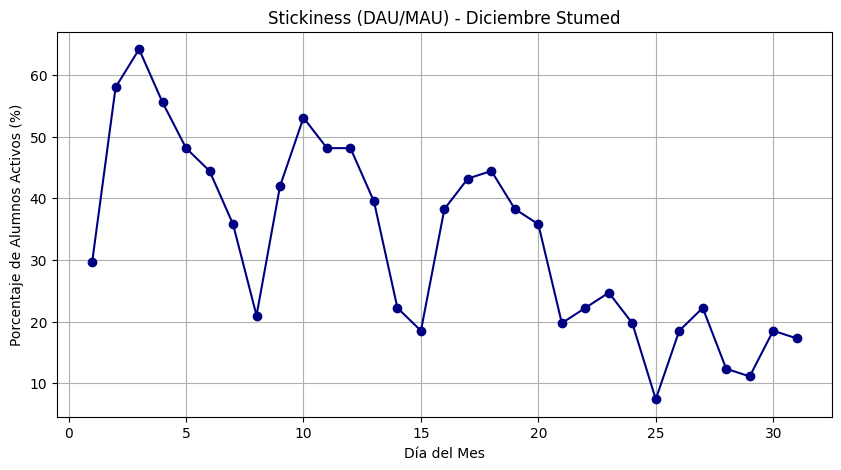

In [282]:
#DAU/MAU Diciembre
#Obtener el mes de diciembre
df_estudiantes_activos_diciembre = df_estudiantes_activos[df_estudiantes_activos['time'].dt.month == 12]
#Obtener número de valores únicos por día en el mes de diciembre
dau_diciembre = df_estudiantes_activos_diciembre.groupby(df_estudiantes_activos_diciembre['time'].dt.day)['user_name'].nunique()
#Obtener número de valores únicos en el mes de diciembre
mau_diciembre = df_estudiantes_activos_diciembre['user_name'].nunique()
#Obtener ratio
dau_mau_ratio_diciembre = dau_diciembre / mau_diciembre
# Multiplicar por 100 para tener porcentajes
dau_mau_ratio_diciembre = (dau_diciembre / mau_diciembre) * 100

#Graficar
plt.figure(figsize=(10,5))
dau_mau_ratio_diciembre.plot(kind='line', marker='o', color='navy')
plt.title('Stickiness (DAU/MAU) - Diciembre Stumed')
plt.xlabel('Día del Mes')
plt.ylabel('Porcentaje de Alumnos Activos (%)')
plt.grid(True)
plt.show()

En diciembre vemos cómo disminuye, con un total de usuarios conectados de 70%, sin embargo vemos como va disminuyendo progresivamente, lo cual coincide con las fechas de vacaciones de Navidad. A pesar de que las vacaciones son hasta el 20 de diciembre, vemos una disminución progresiva desde el inicio del mes.

In [283]:
#FUNCIÓN
def analizar_mes(numero_mes):
    # Diccionario para que el título de la gráfica se vea bonito
    nombres_meses = {
        1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio', 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
    }
    nombre = nombres_meses.get(numero_mes, f"Mes {numero_mes}")

    # 1. Filtrar por el mes elegido
    df_mes = df_estudiantes_activos[df_estudiantes_activos['time'].dt.month == numero_mes]

    # Validar si hay datos en ese mes para evitar errores
    if df_mes.empty:
        return f"No hay datos para el mes {nombre}"

    # 2. Calcular DAU y MAU
    dau = df_mes.groupby(df_mes['time'].dt.day)['user_name'].nunique()
    mau = df_mes['user_name'].nunique()

    # 3. Calcular ratio en porcentaje
    ratio = (dau / mau) * 100

    # 4. Graficar
    plt.figure(figsize=(10, 5))
    ratio.plot(kind='line', marker='o', color='navy')
    plt.title(f'Stickiness (DAU/MAU) - {nombre} Stumed')
    plt.xlabel('Día del Mes')
    plt.ylabel('Porcentaje de Alumnos Activos (%)')
    plt.grid(True)
    plt.show()

    return ratio # Por si quieres ver los números después

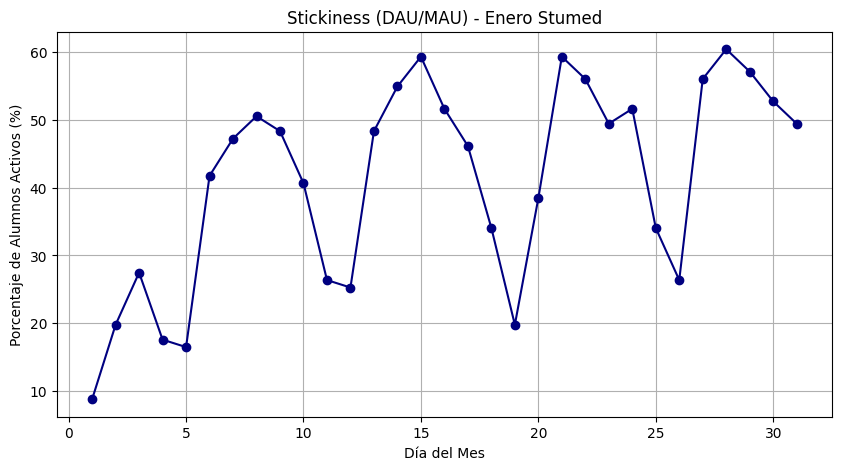

,user_name
time,
1,8.791209
2,19.780220
3,27.472527
4,17.582418
5,16.483516
6,41.758242
7,47.252747
8,50.549451
9,48.351648


In [284]:
#DAU/MAU Enero
analizar_mes(1)

En enero vemos una clara recuperación de los estudiantes, observamos un aumento progresivo de los estudiantes activos, quiere decir que les cuesta arrancar motores pero al final del mes regresamos al 60% que teníamos a inicios de diciembre.

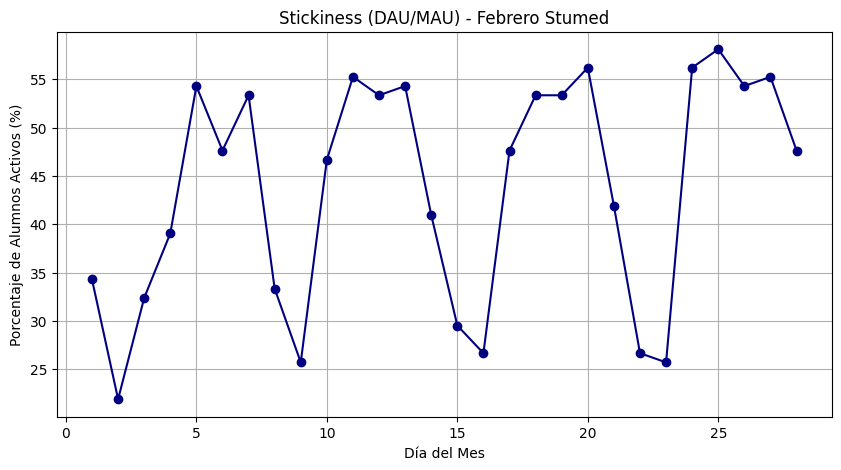

,user_name
time,
1,34.285714
2,21.904762
3,32.380952
4,39.047619
5,54.285714
6,47.619048
7,53.333333
8,33.333333
9,25.714286


In [285]:
#DAU/MAU Febrero
analizar_mes(2)

En febrero vemos que se mantiene un ritmo constante: alumnos conectándose sobre todo los 2 días que tienen las clases entre semana, baja la cantidad un poco en los fines de semana, pero se mantiene un ritmo constante todo el mes. Sin embargo, a diferencia de octubre y noviembre, vemos que nuestro máximo de alumnos conectados es de 55% en el día a día, lo cual disminuyó con respecto a octubre y noviembre.

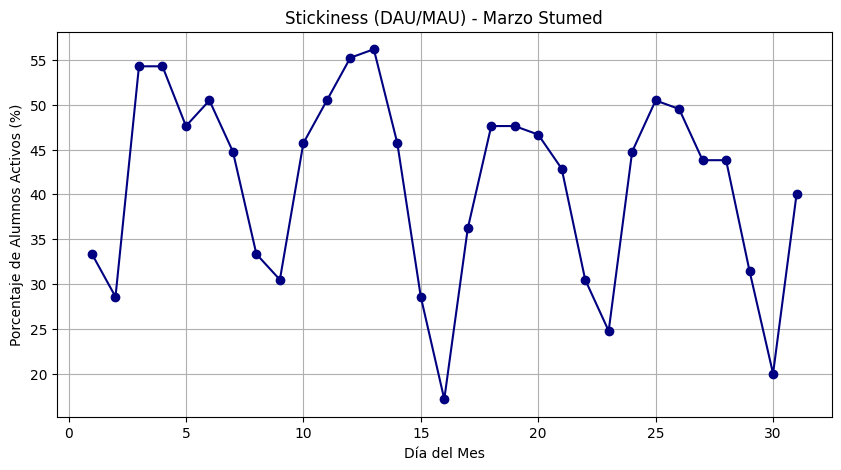

,user_name
time,
1,33.333333
2,28.571429
3,54.285714
4,54.285714
5,47.619048
6,50.476190
7,44.761905
8,33.333333
9,30.476190


In [286]:
#DAU/MAU Marzo
analizar_mes(3)

Obervamos también un patrón constante y similar a febrero. Mantenemos el número de retención de usuarios activos de 55% máximo. Sin embargo, comenzamos a ver picos más bajos, los fines de semana sobre todo, ya casi no se conectan. Vemos un pico muy bajo el 16 de marzo, que fue domingo, lo cual coincide con un puente vacacional en México. Esto nos habla de que los estudiantes no se suelen conectar cuando hay puentes o vacaciones oficiales.

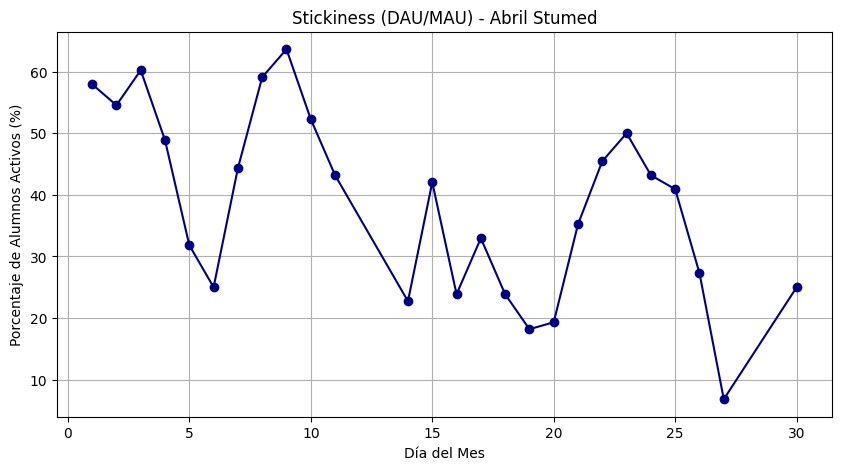

,user_name
time,
1,57.954545
2,54.545455
3,60.227273
4,48.863636
5,31.818182
6,25.000000
7,44.318182
8,59.090909
9,63.636364


In [287]:
#DAU/MAU Abril
analizar_mes(4)

En el mes de Abril. Observamos que hay una caída, esto coincide con las vacaciones de semana santa y pascua en México. Observamos que muchos de los estudiantes no se conectan estas fechas. Otro dato interesante es que comenzamos el mes con un buen número de estudiantes activos, hasta 60%.

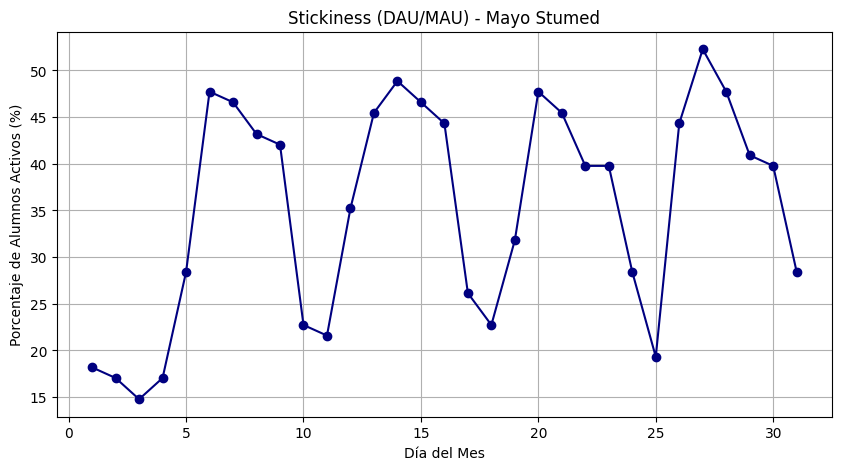

,user_name
time,
1,18.181818
2,17.045455
3,14.772727
4,17.045455
5,28.409091
6,47.727273
7,46.590909
8,43.181818
9,42.045455


In [288]:
#DAU/MAU Mayo
analizar_mes(5)

En el mes de Mayo vemos de nuevo un patrón constante: disminuyendo los fines de semana. Sin embargo vemos que el máximo a disminuído a 50%, y el mínimo bajó hasta 15%, sobre todo al inicio, debido al puente del 1 de mayo.

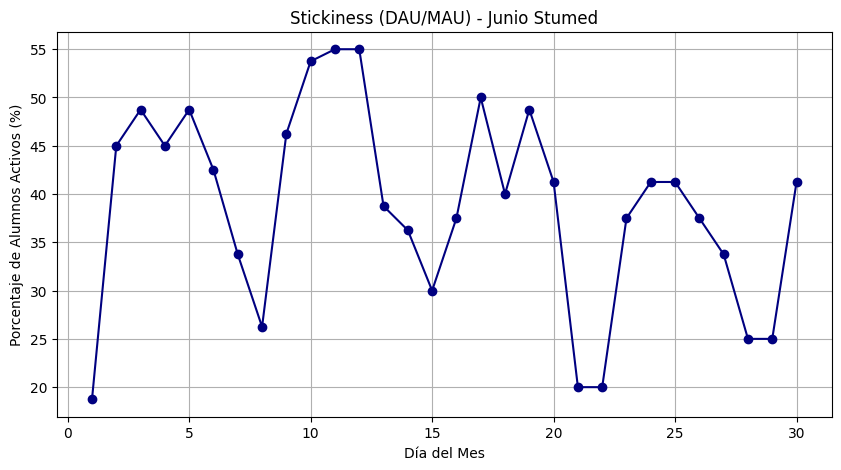

,user_name
time,
1,18.75
2,45.00
3,48.75
4,45.00
5,48.75
6,42.50
7,33.75
8,26.25
9,46.25


In [289]:
#DAU/MAU Junio
analizar_mes(6)

En junio no hay mucha variación, es un mes muy estable comparado con los demás, siguiendo el mismo patrón constante.

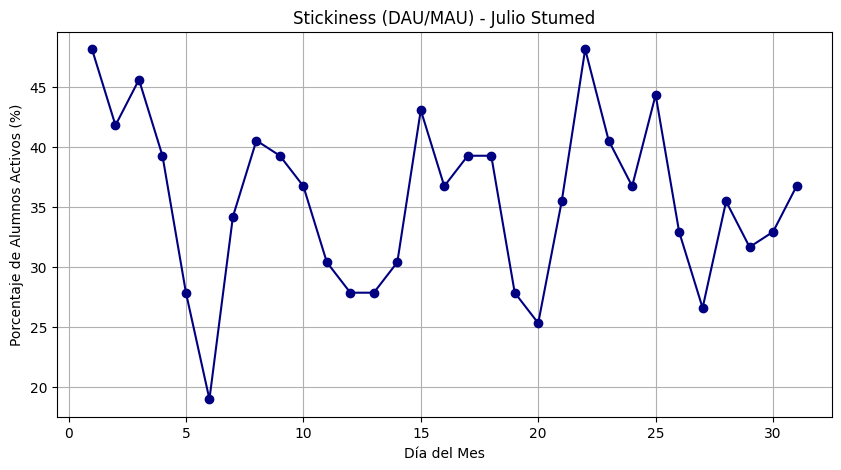

,user_name
time,
1,48.101266
2,41.772152
3,45.569620
4,39.240506
5,27.848101
6,18.987342
7,34.177215
8,40.506329
9,39.240506


In [290]:
#DAU/MAU Julio
analizar_mes(7)

En julio observamos que a pesar de que sigue un patrón relativamente constante, vemos una ligera disiminución de los usuarios activos diariamente, con un máximo de 45%.

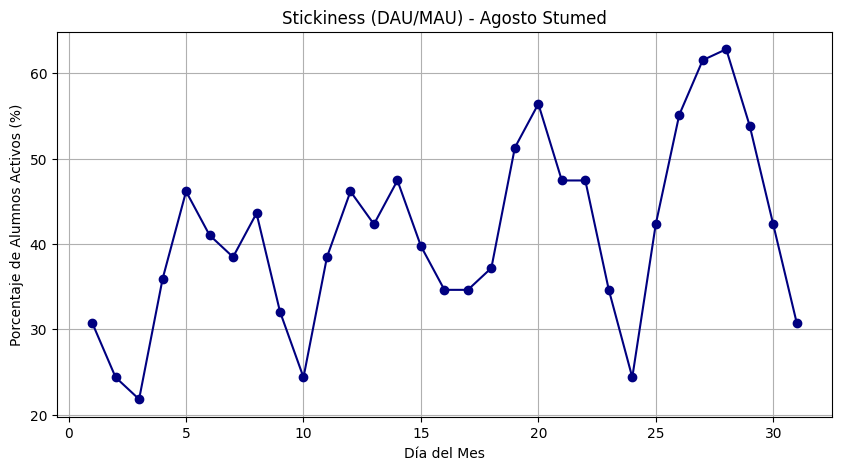

,user_name
time,
1,30.769231
2,24.358974
3,21.794872
4,35.897436
5,46.153846
6,41.025641
7,38.461538
8,43.589744
9,32.051282


In [291]:
#DAU/MAU Agosto
analizar_mes(8)

En agosto vemos un aumento significativo, poco a poco se van conectando más alumnos diariamente, esto debido a que nos acercamos a la fecha del examen. Al final del mes volvemos a tener hasta 60% de los usuarios diarios activos en los días buenos.

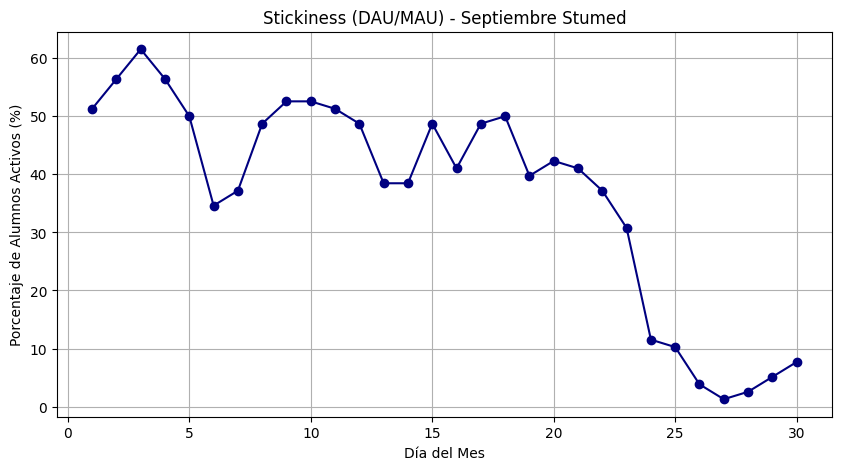

,user_name
time,
1,51.282051
2,56.410256
3,61.538462
4,56.410256
5,50.000000
6,34.615385
7,37.179487
8,48.717949
9,52.564103


In [292]:
#DAU/MAU Septiembre
analizar_mes(9)

En septiembre es el patrón más variable e interesante ya que es el mes del examen. Vemos cómo al inicio del mes hay muchos usuarios conectados al día, disminuye muy lentamente ya que muchos estudiantes están activos durante todo el mes, sin embargo si empezamos a ver una ligera disminución. El 24 de septiembre hay una caída abrupta, lo que coincide con los días en los que empieza el examen.

#### Tasa de actividad por ciclo escolar

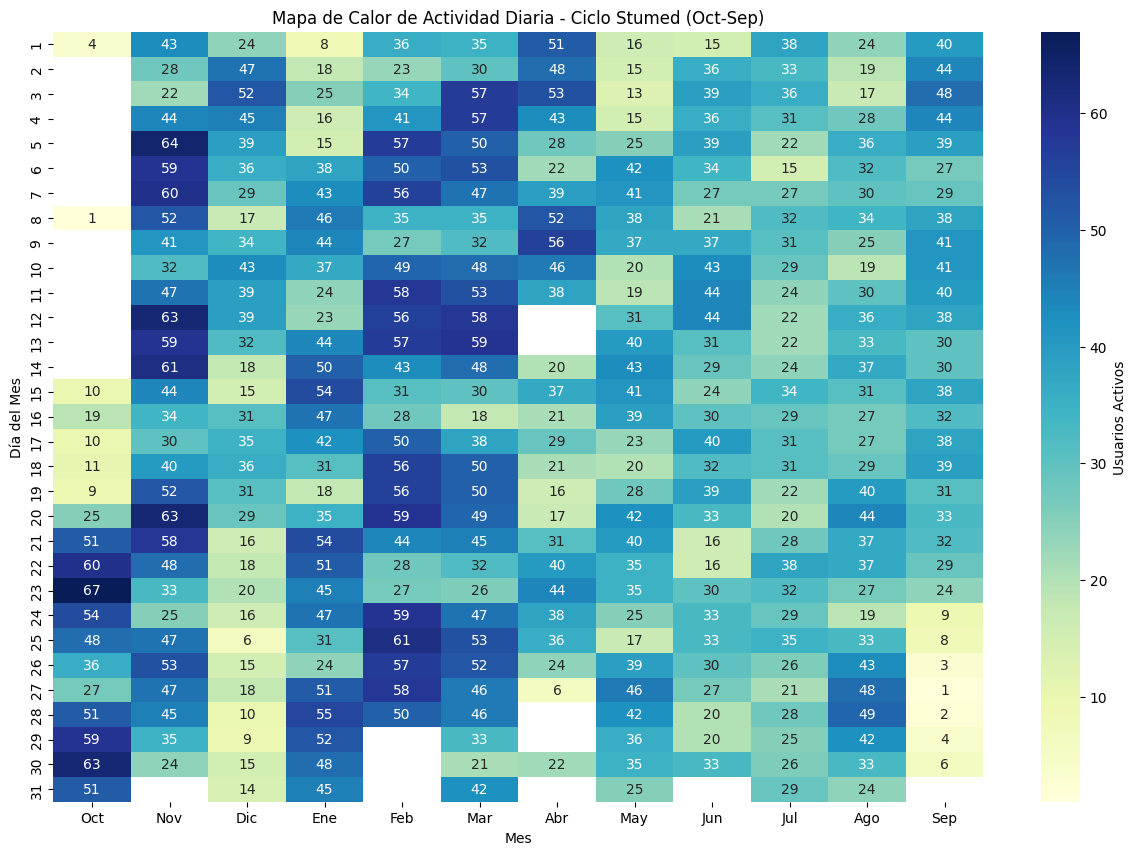

In [293]:
#Headmap de actividad por todo el ciclo escolar (octubre 2024-septiembre 2025)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparar los datos (Asegúrate de que 'time' sea datetime)
df_heatmap = df_estudiantes_activos.copy()
df_heatmap['Day'] = df_heatmap['time'].dt.day
df_heatmap['Month'] = df_heatmap['time'].dt.month

# 2. Crear la tabla pivote contando usuarios ÚNICOS por día
# Esto nos da el DAU para cada celda del calendario
pivot_table = df_heatmap.pivot_table(
    index='Day',
    columns='Month',
    values='user_name',
    aggfunc='nunique'
)

# 3. REORDENAR las columnas para que sigan el ciclo escolar (Oct -> Sep)
# De lo contrario, aparecerán de Enero a Diciembre por defecto
orden_ciclo = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Solo incluimos los meses que realmente tengan datos para evitar errores
meses_presentes = [m for m in orden_ciclo if m in pivot_table.columns]
pivot_table = pivot_table[meses_presentes]

# Opcional: Cambiar los números de los meses por nombres para que se vea profesional
nombres_meses = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'}
pivot_table.columns = [nombres_meses[m] for m in pivot_table.columns]

# 4. Graficar
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Usuarios Activos'})
plt.title('Mapa de Calor de Actividad Diaria - Ciclo Stumed (Oct-Sep)')
plt.xlabel('Mes')
plt.ylabel('Día del Mes')
plt.show()

Conclusión: Análisis de Engagement y Dinámica del Aspirante (Ciclo 2024-2025)
La visualización del mapa de calor revela que el compromiso con la plataforma no es lineal, sino que está profundamente influenciado por factores psicológicos de persistencia y por el calendario cultural mexicano:

Desgaste del Compromiso Académico (Churn de Comportamiento): Se observa un fenómeno de "entusiasmo inicial" con una alta densidad de usuarios entre octubre y enero. Sin embargo, a partir de marzo se hace evidente una pérdida gradual de tracción. Dado que el pago del curso es obligatorio y por adelantado, este descenso no es una deserción financiera, sino una claudicación en el proceso de estudio, donde el aspirante desiste de la competencia debido a la carga del temario o la falta de constancia a largo plazo.

Impacto de la Estacionalidad Cultural (Semana Santa y Pascua): El "hoyo" de actividad detectado en el mes de abril correlaciona exactamente con el periodo de Semana Santa y Pascua en México. Este es el punto de menor actividad en todo el ciclo (fuera de las fechas decembrinas), lo que indica que el estudiante promedio de Stumed prioriza el descanso absoluto en este periodo, rompiendo el hábito de estudio por completo durante esas dos semanas.

Patrones de Estudio Semanal: La fluctuación de colores confirma que el uso de la plataforma es una actividad de "días hábiles". La caída sistemática en los fines de semana sugiere que el alumno percibe el contenido digital como una tarea de rutina diaria, dejando los sábados y domingos para el descanso o, posiblemente, para métodos de estudio análogos (lectura de manuales físicos) que no requieren conexión.

Recta Final y Abandono Crítico: La drástica disminución de actividad en las semanas previas al examen (finales de agosto y septiembre) sugiere que el grupo de alumnos que logra mantener la disciplina hasta el final es reducido. Los que no mantuvieron un ritmo constante en los meses "fríos" (mayo-junio) tienden a no presentarse a la fase final de preparación intensa.

#### Actividad por día de la semana

/tmp/ipython-input-3054548809.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dia_es', y='usuarios_unicos', data=resumen_semanal, palette='Blues_d')


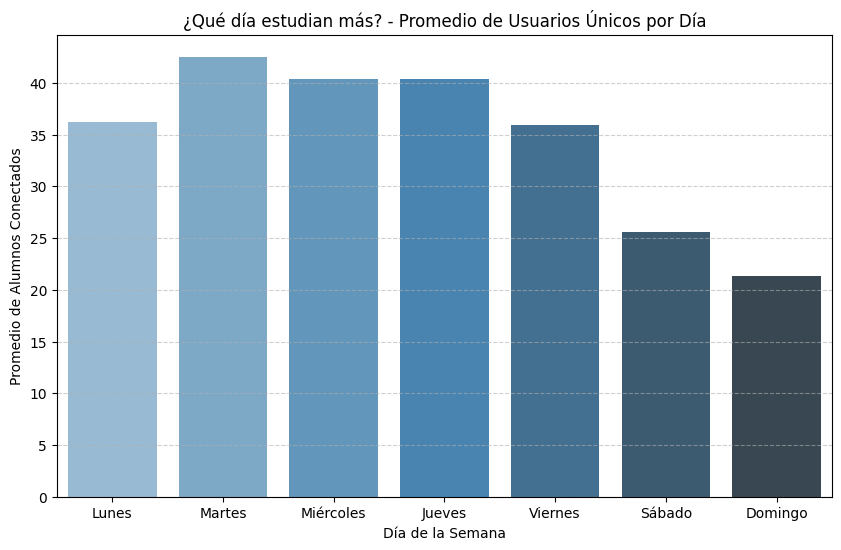

In [294]:

# 1. Asegúrate de que 'time' sea formato fecha
df_estudiantes_activos['time'] = pd.to_datetime(df_estudiantes_activos['time'])

# 2. Paso clave: Contar cuántos usuarios únicos hubo CADA DÍA del año
# Agrupamos por la fecha completa (Año-Mes-Día)
dau_diario = df_estudiantes_activos.groupby(df_estudiantes_activos['time'].dt.date)['user_name'].nunique().reset_index()
dau_diario.columns = ['fecha', 'usuarios_unicos']

# 3. Extraer el nombre del día de la semana de esa fecha
dau_diario['fecha'] = pd.to_datetime(dau_diario['fecha'])
dau_diario['dia_semana'] = dau_diario['fecha'].dt.day_name()
# También sacamos el número (0=Lunes, 6=Domingo) para poder ordenar la gráfica
dau_diario['dia_num'] = dau_diario['fecha'].dt.dayofweek

# 4. Traducir los días al español
dias_traduccion = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
dau_diario['dia_es'] = dau_diario['dia_semana'].map(dias_traduccion)

# 5. Calcular el PROMEDIO de usuarios por cada día de la semana
resumen_semanal = dau_diario.groupby(['dia_num', 'dia_es'])['usuarios_unicos'].mean().reset_index()

# 6. Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='dia_es', y='usuarios_unicos', data=resumen_semanal, palette='Blues_d')
plt.title('¿Qué día estudian más? - Promedio de Usuarios Únicos por Día')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Alumnos Conectados')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Vemos que el día que más estudian son los martes, sin embargo es muy parejo todos los días entre semana. Asimismo observamos una disminución gradual a partir del martes. Pero los días que vemos menos estudiantes son los fines de semana sobre todo el domingo.

#### Time to First Activity:

¿Cuánto tarda un alumno desde que se inscribe hasta que completa su primera clase o quiz? Si tarda más de 48 horas, corres riesgo de que pierda el impulso inicial.
$$TTFA = Fecha\_Primer\_Log - Fecha\_Registro$$

In [295]:
# 1. Obtener solo la PRIMERA actividad de cada alumno
df_primera_actividad = df_estudiantes_activos.groupby('user_name')['time'].min().reset_index()
df_primera_actividad.columns = ['user_name', 'fecha_primer_log']

# 2. Unir con la fecha de inscripción
df_ttfa = pd.merge(df_primera_actividad, df_alumnos_inscripciones[['user_name', 'enrolment_start']], on='user_name', how='left')

# 3. Calcular la métrica (Actividad - Inscripción)
df_ttfa['diferencia'] = df_ttfa['fecha_primer_log'] - df_ttfa['enrolment_start']

# 4. Convertir a horas para que sea fácil de graficar
# Usamos .total_seconds() / 3600 para obtener horas decimales
df_ttfa['ttfa_horas'] = df_ttfa['diferencia'].dt.total_seconds() / 3600

# 5. Limpieza: Si alguien tiene horas negativas (por errores de sistema), los quitamos
df_ttfa = df_ttfa[df_ttfa['ttfa_horas'] >= 0]

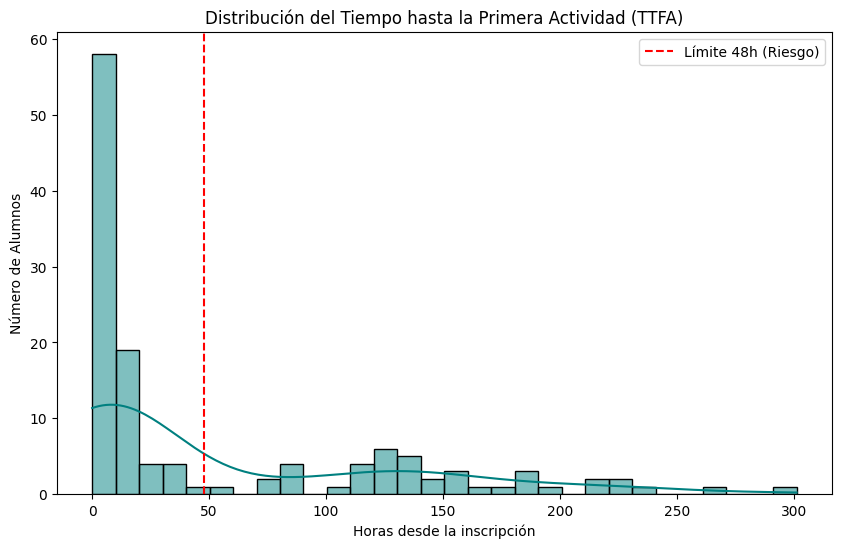

In [296]:
#Eliminar valores atípicos "user_name = Shunashi Janett Perez Lopez"
df_ttfa = df_ttfa[df_ttfa['user_name'] != 'Shunashi Janett Perez Lopez']
#Graficar
plt.figure(figsize=(10,6))
sns.histplot(df_ttfa['ttfa_horas'], bins=30, kde=True, color='teal')

# Añadir una línea roja en las 48 horas (tu zona de riesgo)
plt.axvline(x=48, color='red', linestyle='--', label='Límite 48h (Riesgo)')

plt.title('Distribución del Tiempo hasta la Primera Actividad (TTFA)')
plt.xlabel('Horas desde la inscripción')
plt.ylabel('Número de Alumnos')
plt.legend()
plt.show()

print()

La plataforma muestra una excelente capacidad de atracción inicial, con más del 70% de los usuarios realizando su primera actividad académica en menos de 24 horas tras su matriculación. Sin embargo, existe un segmento crítico que supera el umbral de las 48 horas (línea roja), mostrando un inicio tardío que podría correlacionarse con una menor constancia a largo plazo. Se recomienda implementar un sistema de recordatorios automatizados para aquellos usuarios que no registren actividad en sus primeras 36 horas para capitalizar el impulso inicial de inscripción.

### KPIs de Progreso hacia el Objetivo (Septiembre)

#### Course Completion Velocity:

¿A qué ritmo avanzan? ¿Para el mes de julio, cuánto porcentaje de sus sesiones totales han alcanzado?

Cálculo: $\frac{\text{Lecciones Completadas}}{\text{Lecciones completadas hasta Julio}}$

### KPIs de Desempeño Académico (Calidad del Aprendizaje)

#### Average Quiz Score por Especialidad:

¿En qué áreas salen peor (Ginecología, Pediatría, etc.)? Esto le sirve a Stumed para crear sesiones de refuerzo en vivo sobre esos temas específicos.

#### Diferencia de cursos completados

¿Cuáles cursos son los que suelen completar más?

#### Correlación: Tiempo en Plataforma vs. Calificación:

¿Realmente pasar más horas en Moodle se traduce en mejores notas en los simulacros?

### KPIs de uso activo

#### Tasa de Estudiantes "Zombies":

Porcentaje de alumnos inscritos que no tuvieron actividad en los últimos 4 meses.

##### Descripción de perfil de alumno fantasma

¿Se inscribieron tarde? ¿Reprobaron el primer simulacro?, ¿cuánto tiempo pasan en línea?, ¿cuánto tiempo pasó desde que se inscribieron e iniciaron?

##### Cómo identificar un estudiante zoombie antes de tiempo

#### Métrica de "Fatiga del Temario":

Comparar cuántas lecciones se completan al mes. Es común que en los primeros meses completen 20 lecciones y para junio solo 5. Detectar esta caída es clave para enviar recordatorios.

#### Último Acceso Significativo

No solo la última vez que entró, sino la última vez que aprobó un quiz.

### Análisis de Embudo (Funnel) de Contenidos

#### Drop-off Rate por Especialidad.

Cuánto porcentaje de alumnos acabó cada curso

## Perfil de estudiantes

### Inscripción temprana

#### Curva de Deserción por Cohorte de Inscripción:

Calcular ciclo de vida y cómo se comparta la actividad de esa cohorte a lo largo del ciclo.
(estudiantes_activos)

#### $$TTFA = Fecha\_Primer\_Log - Fecha\_Registro$$

#### Course Completion Velocity: ¿A qué ritmo avanzan? Necesitas saber si, al ritmo actual, el estudiante terminará el temario para agosto.

Cálculo: $\frac{\text{Lecciones Completadas}}{\text{Semanas restantes hasta Septiembre}}$

### Intensivo

### Super Intensivo

### Estudiantes Gold Standard

¿Cuántas horas totales de video vio un alumno que terminó el 100% del curso?

¿Cuántas veces repitió los quizes en promedio?

¿En qué mes se inscribió la mayoría de los que completaron el curso?

## HIPÓTESIS

### Relación actividades vs tiempo

¿Hay alumnos que pasan mucho tiempo conectados pero completan pocas actividades? Esto indicaría que el contenido es difícil de digerir o que el alumno deja la sesión abierta sin estudiar realmente.

### Momento de inscripción vs nivel de compromiso

Hipótesis: Los que pagaron desde octubre (con mucha anticipación) ¿mantienen la constancia o se confían y bajan el ritmo en marzo?

Hipótesis: Los que se inscriben en mayo (pagando el total a pesar de tener menos tiempo) ¿son más intensos en sus horas de estudio diario?

## Conclusiones